In [1]:
%load_ext autoreload
%autoreload 2

import os

import matplotlib as mpl
import pandas as pd
from matplotlib import animation

from sync.elastic import ELASTIC
from tools.animator import Animator
from tools.sportec_data import SportecData

pd.set_option('display.width', 250)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)

%matplotlib inline
mpl.rcParams['animation.embed_limit'] = 100

### Data Preparation

This tutorial demonstrates how to apply ELASTIC to the [Sportec Open DFL Dataset (Bassek et al., 2025)](https://www.nature.com/articles/s41597-025-04505-y). It consists of event and tracking data from seven matches of German Bundesliga's first and second divisions, and can be downloaded from [this link](https://springernature.figshare.com/articles/dataset/An_integrated_dataset_of_spatiotemporal_and_event_data_in_elite_soccer/28196177).
| match_id | home                  | away                   |
|:--------:|-----------------------|------------------------|
| J03WMX   | 1. FC Köln            | FC Bayern München      |
| J03WN1   | VfL Bochum 1848       | Bayer 04 Leverkusen    |
| J03WPY   | Fortuna Düsseldorf    | 1. FC Nürnberg         |
| J03WOH   | Fortuna Düsseldorf    | SSV Jahn Regensburg    |
| J03WQQ   | Fortuna Düsseldorf    | FC St. Pauli           |
| J03WOY   | Fortuna Düsseldorf    | F.C. Hansa Rostock     |
| J03WR9   | Fortuna Düsseldorf    | 1. FC Kaiserslautern   |

After downloading the data, place the XML files by type in the following directories:
- Match information: `data/sportec/metadata`
- Event data: `data/sportec/event`
- Tracking data: `data/sportec/tracking`

Then, choose the match ID you want to synchronize and run the following code.

In [11]:
# It can take about one or two minutes to parse tracking data using kloppy
match_id = "J03WMX"
match = SportecData(match_id)
match.lineup.head()

Loading the tracking data...
Transforming the tracking data coordinates...


,team_id,team_name,home_away,player_id,uniform_number,object_id,player_name,starting,playing_position,captain
0,DFL-CLU-00000G,FC Bayern München,away,DFL-OBJ-0027KL,2,away_2,Dayot Upamecano,True,RCB,False
1,DFL-CLU-00000G,FC Bayern München,away,DFL-OBJ-J017RE,4,away_4,M. de Ligt,True,LCB,False
2,DFL-CLU-00000G,FC Bayern München,away,DFL-OBJ-0027G0,5,away_5,Benjamin Pavard,True,RB,False
3,DFL-CLU-00000G,FC Bayern München,away,DFL-OBJ-0002F5,6,away_6,Joshua Kimmich,True,RDM,False
4,DFL-CLU-00000G,FC Bayern München,away,DFL-OBJ-0027G6,7,away_7,Serge Gnabry,True,CF,False


We categorize events based on [SPADL (Decroos et al., 2019)](https://arxiv.org/abs/1802.07127). The following code converts Sportec event data into the SPADL format and prepares it as a proper input for ELASTIC. (For details on the required input formats, see `sync/schema.py`.)

In [12]:
input_events = match.format_events_for_syncer()
input_events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success
0,1,2023-05-27 13:30:12.230,away_7,pass,52.50,34.00,True
1,1,2023-05-27 13:30:15.059,away_2,pass,66.73,34.20,False
2,1,2023-05-27 13:30:33.781,home_2,throw_in,25.35,0.00,False
3,1,2023-05-27 13:30:34.963,away_2,clearance,55.10,5.92,True
4,1,2023-05-27 13:30:36.890,away_38,pass,49.79,12.04,True
...,...,...,...,...,...,...,...
1313,2,2023-05-27 15:25:18.831,away_13,bad_touch,14.43,66.09,False
1314,2,2023-05-27 15:25:32.004,home_3,throw_in,19.64,68.00,True
1315,2,2023-05-27 15:25:32.723,home_14,pass,38.37,64.99,False
1316,2,2023-05-27 15:25:35.767,away_2,interception,55.10,62.28,True


Similarly, tracking data can also be converted into the ELASTIC input format.

In [13]:
input_tracking = match.format_tracking_for_syncer()
input_tracking

,frame_id,period_id,timestamp,utc_timestamp,player_id,ball,x,y,z,speed,accel_s,accel_v
0,10000,1,0.00,2023-05-27 13:30:12.230,home_11,False,45.60,28.88,NaN,2.268998,4.336645,4.426080
1,10001,1,0.04,2023-05-27 13:30:12.270,home_11,False,45.68,28.90,NaN,2.268998,4.336645,4.426080
2,10002,1,0.08,2023-05-27 13:30:12.310,home_11,False,45.78,28.92,NaN,2.440260,3.928779,3.999347
3,10003,1,0.12,2023-05-27 13:30:12.350,home_11,False,45.88,28.95,NaN,2.596585,3.516135,3.573732
4,10004,1,0.16,2023-05-27 13:30:12.390,home_11,False,46.00,28.98,NaN,2.737852,3.098715,3.149091
...,...,...,...,...,...,...,...,...,...,...,...,...
1963482,175122,2,3004.88,2023-05-27 15:25:48.270,None,True,56.30,45.69,4.27,8.015545,-16.209402,16.209472
1963483,175123,2,3004.92,2023-05-27 15:25:48.310,None,True,56.60,45.72,3.91,7.307041,-23.313918,23.314344
1963484,175124,2,3004.96,2023-05-27 15:25:48.350,None,True,56.88,45.77,3.55,6.334487,-26.642226,26.642184
1963485,175125,2,3005.00,2023-05-27 15:25:48.390,None,True,57.17,45.80,3.18,5.303477,-28.424946,28.425434


### Data Sychronization

By running the following code, you can synchronize the event and tracking data with these four stages:
1. Kick-off synchronization
2. Major event synchronization (for pass-like, incoming, and set-piece events)
3. Receive detection (for pass-like and set-piece events)
4. Minor event synchronization (for `tackle`, `foul`, `bad_touch`, `take_on`, and `dispossessed`)

<p align="center">
  <img src="docs/sync_stages.png" width="500" />
</p>

In [35]:
syncer = ELASTIC(input_events, input_tracking)
syncer.run()

Post-syncing minor events: 100%|██████████| 150/150 [00:02<00:00, 67.28it/s]


As a result, the synchronized timstamps are stored in `frame_id` and `synced_ts` columns. The detected end timestamps of pass-like and set-piece events are stroed in `receive_frame_id` and `receive_ts` columns.

In [36]:
syncer.events

,period_id,utc_timestamp,player_id,spadl_type,start_x,start_y,success,next_player_id,next_type,frame_id,receiver_id,receive_frame_id,synced_ts,receive_ts
0,1,2023-05-27 13:30:12.230,away_7,pass,52.50,34.00,True,away_2,pass,10000.0,away_2,10025.0,00:00.00,00:01.00
1,1,2023-05-27 13:30:15.059,away_2,pass,66.73,34.20,False,home_2,throw_in,10040.0,out,10131.0,00:01.60,00:05.24
2,1,2023-05-27 13:30:33.781,home_2,throw_in,25.35,0.00,False,away_2,clearance,10415.0,away_2,10512.0,00:16.60,00:20.48
3,1,2023-05-27 13:30:34.963,away_2,clearance,55.10,5.92,True,away_38,pass,10512.0,away_38,10547.0,00:20.48,00:21.88
4,1,2023-05-27 13:30:36.890,away_38,pass,49.79,12.04,True,away_6,pass,10547.0,away_6,10586.0,00:21.88,00:23.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,2,2023-05-27 15:25:18.831,away_13,bad_touch,14.43,66.09,False,home_3,throw_in,174395.0,None,NaN,49:35.80,NaN
1314,2,2023-05-27 15:25:32.004,home_3,throw_in,19.64,68.00,True,home_14,pass,174683.0,home_14,174720.0,49:47.32,49:48.80
1315,2,2023-05-27 15:25:32.723,home_14,pass,38.37,64.99,False,away_2,interception,174724.0,away_2,174769.0,49:48.96,49:50.76
1316,2,2023-05-27 15:25:35.767,away_2,interception,55.10,62.28,True,home_20,goalkick,174769.0,None,NaN,49:50.76,NaN


### Animating Events and Trajectories 

To check the result of synchronization, you can generate an animation of player and ball trajectories with raw/synchronized events by running the following code. Feel free to choose which segment to visualize by modifying `start_frame` and `end_frame`!

In [16]:
# By default, this code generates and animation for the given match's first minute
start_frame = 10000
end_frame = 11500

merged_data = SportecData.merge_synced_events_and_tracking(syncer.events, match.tracking, match.fps, ffill=True)
segment_data = merged_data.set_index("frame_id").loc[start_frame:end_frame].copy()
animator = Animator({"main": segment_data}, show_events=True)
anim = animator.run()

writer = animation.FFMpegWriter(fps=match.fps)
os.makedirs("animations", exist_ok=True)
anim_path = f"animations/sportec_{match_id}_{start_frame}-{end_frame}.mp4"
anim.save(anim_path, writer=writer)

### Visualizing Individual Windows

To check how ELASTIC decided the best timestamp for each event, you can plot features for the given event.

Event 1: pass by away_2
Matched frame: 10040
Matched time: P1-00:01.60


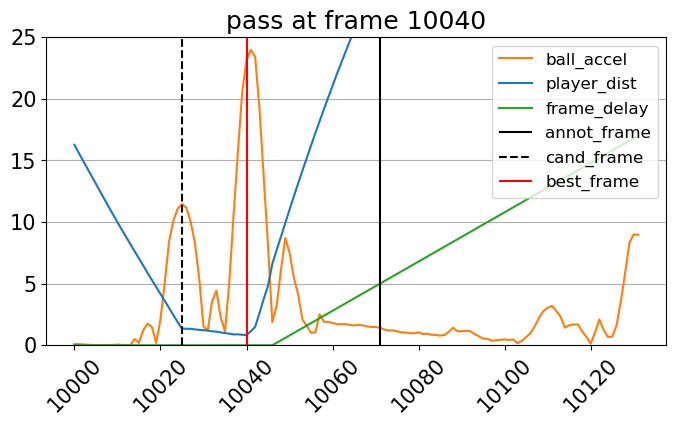

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,kick_dist,score
frame_id,,,,,,,,
10025,0,1.387579,4.925234,57.283149,0.11,1.28969,1.350926,71.007212
10040,0,1.852186,5.889424,119.935553,0.04,0.83863,59.492619,93.011418


In [37]:
# pass-like event
syncer.plot_window_features(1)

Event 27: interception by home_6
Matched frame: 12314
Matched time: P1-01:32.56


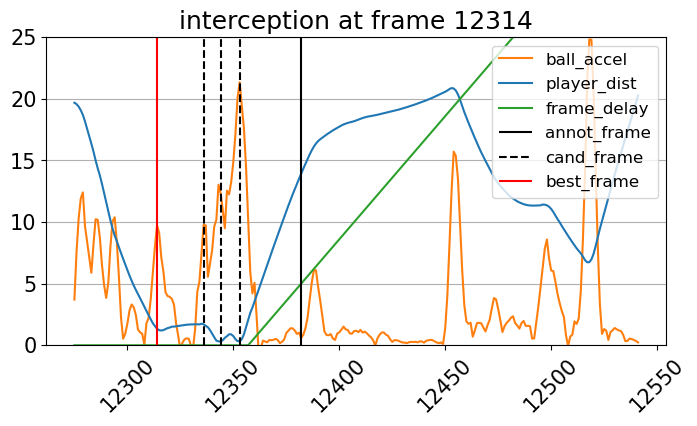

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,rel_speed,rel_accel,kick_dist,score
frame_id,,,,,,,,,,
12314,0,6.550324,4.035856,48.626768,0.01,1.199067,1.902643,48.626768,19.687417,90.007778
12336,0,6.121765,2.398101,48.970335,0.30,1.232023,1.236176,48.970335,1.749103,73.478656
12344,0,6.073212,2.296888,65.126062,0.13,0.307151,4.983630,61.694113,1.700514,80.942976
12353,0,5.744641,0.977533,106.793076,0.46,0.331287,14.802793,106.793076,0.892860,76.703578


In [38]:
# incoming event
syncer.plot_window_features(27)

Current event: pass by away_7
Next event: pass by away_2

Detected receiver: away_2
Receiving frame: 10025.0
Receiving time: P1-00:01.00


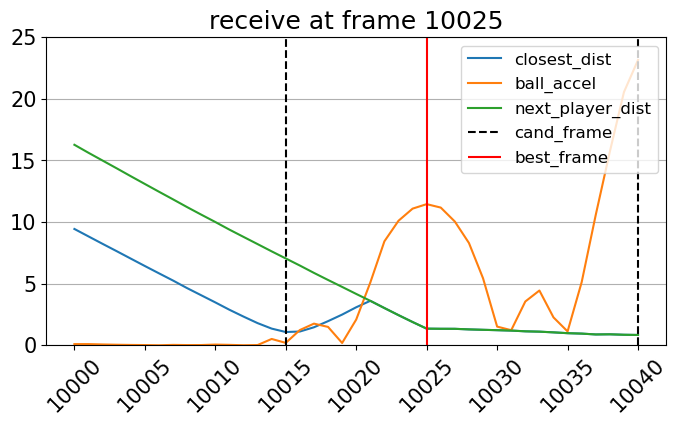

,ball_height,ball_accel,next_player_dist,closest_id,closest_dist,kick_dist,score
frame_id,,,,,,,
10015,0.06,8.787770,5.301868,away_6,1.076708,9.227340,52.012146
10025,0.11,57.283149,1.289690,away_2,1.289690,5.696776,78.505169
10040,0.04,115.802664,0.838630,away_2,0.838630,0.512296,63.584315


In [39]:
# receive
syncer.receive_det.plot_window_features(0)

Event 178: tackle by home_2
Matched frame: 24335
Matched time: P1-09:33.40


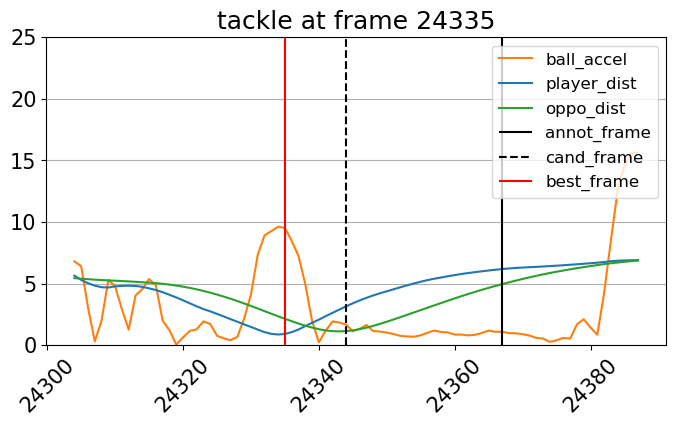

,frame_delay,player_speed,player_accel,ball_accel,ball_height,player_dist,oppo_id,oppo_rel_x,oppo_rel_y,oppo_dist,kick_dist,score
frame_id,,,,,,,,,,,,
24335,0,2.646399,4.593431,48.121773,0.02,0.874458,away_38,-2.14,0.19,1.589972,3.158787,76.205613
24344,2,3.622078,3.328546,9.661285,0.02,2.364335,away_38,-0.53,1.01,1.127187,6.908222,66.064475


In [40]:
# minor event
syncer.plot_window_features(178)